## Understanding Dvae


In [1]:
import torch

import torchvision.transforms.functional as TF
import torchvision.transforms as T
import torchvision

In [2]:
import cv2
from matplotlib import pyplot as plt
import os
import sys
import numpy as np


In [3]:
sys.path.insert(0, '/home/jaswant/Documents/DiscreteVAE/src')

In [4]:
data_folder = "/home/jaswant/Documents/DiscreteVAE/data/Images"

In [5]:
sample_image = os.path.join(data_folder, "n02085620-Chihuahua/n02085620_326.jpg")

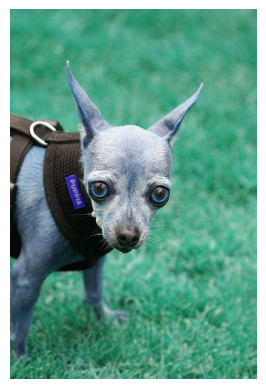

In [6]:
sample_image = cv2.imread(sample_image)

plt.axis('off')
plt.imshow(sample_image)

## Defining the Dataset

In [7]:
class DogDataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, transform=None) -> None:
        super().__init__()

        self._img_paths = []
        for path, subdirs, files in os.walk(data_folder):
            for name in files:
                self._img_paths.append(os.path.join(path, name))


        # self._img_paths = [os.path.join(data_folder, f)
        #                    for f in os.listdir(data_folder)]
        self._target_img_size = 256
        self._transform = transform

        # self._to_tensor = T.ToTensor()

    def __len__(self):
        return len(self._img_paths)

    def __getitem__(self, index):
        selected_img_path = self._img_paths[index]

        img = cv2.imread(selected_img_path)

        h, w, _ = img.shape

        r = self._target_img_size / min(h, w)
        s = (round(r * h), round(r*w))
        # print(f'New size: {s}')

        img = cv2.resize(img, s, interpolation=cv2.INTER_CUBIC)

        h, w, _ = img.shape

        # Center crop
        x = w/2 - self._target_img_size/2
        y = h/2 - self._target_img_size/2

        crop_img = img[int(y):int(y+self._target_img_size),
                       int(x):int(x+self._target_img_size)]
        
        # crop_img = crop_img.astype(np.float16)

        # img = TF.center_crop(img, output_size=2 * [self._target_img_size])
        # img = torch.unsqueeze(T.ToTensor()(crop_img), 0)

        if self._transform:
            img_tensor = self._transform(crop_img)
        else:
            img_tensor = crop_img

        # img_tensor = self._to_tensor(img_tensor)

        return img_tensor


In [8]:
dog_data = DogDataset(data_folder=data_folder)

In [9]:
# dogs = torch.stack([dog for dog in dog_data])

In [10]:
# mean = dogs.view(3, -1).mean(dim=1)
# std = dogs.view(3, -1).std(dim=1)

# print(f'Dataset Mean: {mean}, STD: {std}')

In [11]:
mean_tensor = (0.4360, 0.4408, 0.4332)
std_tensor = (0.2619, 0.2639, 0.2616)

In [12]:
dog_data_normalized = DogDataset(data_folder=data_folder, transform=T.Compose([T.ToTensor(), T.Normalize(mean=mean_tensor, std=std_tensor)]))

In [13]:
sample_index = 178
sample_dog = dog_data_normalized[sample_index]
sample_dog.shape

torch.Size([3, 256, 256])

In [14]:
sample_dog

tensor([[[ 0.7460,  1.0754,  1.2551,  ..., -1.5450, -1.4102, -1.4402],
         [ 1.2551,  0.8358,  0.7759,  ..., -1.4701, -1.3503, -1.3952],
         [ 1.3749,  0.6412,  0.7610,  ..., -1.3353, -1.4551, -1.3503],
         ...,
         [-1.5150, -1.4701, -1.3653,  ..., -1.1257, -1.0658, -1.0808],
         [-1.5150, -1.4551, -1.3803,  ..., -1.1257, -1.2006, -0.9909],
         [-1.4851, -1.4402, -1.3653,  ..., -1.1856, -1.2006, -1.1257]],

        [[ 0.5587,  0.8262,  0.9748,  ..., -1.6257, -1.4028, -1.4326],
         [ 1.1531,  0.6776,  0.5735,  ..., -1.5514, -1.3731, -1.4028],
         [ 1.4206,  0.6330,  0.6478,  ..., -1.4326, -1.4920, -1.3880],
         ...,
         [-1.3434, -1.3137, -1.2691,  ..., -0.6598, -0.5855, -0.6004],
         [-1.3583, -1.3434, -1.2840,  ..., -0.6450, -0.7639, -0.5707],
         [-1.3434, -1.3285, -1.2840,  ..., -0.7193, -0.7787, -0.7044]],

        [[ 0.5926,  0.8775,  1.0124,  ..., -1.4611, -0.6966, -0.6666],
         [ 1.2073,  0.7575,  0.6376,  ..., -1

In [15]:
# sample_dog_reconstructed = sample_dog.permute(1, 2, 0).numpy().copy()
# plt.axis('off')
# plt.imshow(sample_dog_reconstructed)

In [16]:
from discretevae import Encoder, Decoder, DiscreteVAE2

In [20]:
num_tokens=8192
codebook_dim=2048
num_groups=4
hidden_base=256
num_blocks_per_group=2
num_layers_per_block=2
num_decoder_init=64
temperature=0.9
reconstrution_loss='smooth_l1_loss'
kl_div_loss_weight=0.1
logit_laplace_eps=None

dvae2 = DiscreteVAE2(num_tokens=num_tokens, codebook_dim=codebook_dim, 
                    num_groups=num_groups, hidden_base=hidden_base, 
                    num_blocks_per_group=num_blocks_per_group, num_layers_per_block=num_layers_per_block, 
                    num_decoder_init=num_decoder_init, temperature=temperature, 
                    reconstrution_loss=reconstrution_loss, kl_div_loss_weight=kl_div_loss_weight, 
                    logit_laplace_eps=None)


In [21]:
# encoder = Encoder(num_tokens=num_tokens, num_groups=num_groups, hidden_base=hidden_base,
#                     num_blks_per_grp=num_blocks_per_group, num_layers_per_blk=num_layers_per_block)

# decoder = Decoder(hidden_base=hidden_base, codebook_dim=codebook_dim, num_groups=num_groups, 
#                         n_init=num_decoder_init, num_blocks_per_group=num_blocks_per_group, num_layers_per_block=num_layers_per_block)

In [22]:
total_params = sum(p.numel() for p in dvae2.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 248547398


In [19]:
from torch.utils.data import DataLoader

dog_dataloader = DataLoader(dog_data_normalized, batch_size=8, shuffle=True)
# test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [29]:
dvae2._encoder

Encoder(
  (blocks): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
    )
    (1): EncoderGroup(
      (_group): Sequential(
        (0): EncoderBlock(
          (ch_equalizer): Identity()
          (residual): Sequential(
            (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (3): ReLU()
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (5): ReLU()
            (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
            (7): ReLU()
          )
        )
        (1): EncoderBlock(
          (ch_equalizer): Identity()
          (residual): Sequential(
            (0): Conv2d(256, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): ReLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), st

In [20]:
i = 0
for dog_batch in dog_dataloader:
    sample_dog_batch = dog_batch
    i += 1
    if i > 5:
        break

In [21]:
sample_out = dvae2(sample_dog_batch)

In [22]:
sample_out[1].shape

torch.Size([8, 3, 256, 256])

In [ ]:
# sample_out[0]

In [ ]:
# sample_dog_image = sample_dog_batch[0].permute(1, 2, 0).detach().numpy().copy()
# sample_dog_reconstructed = sample_out[1][0].permute(1, 2, 0).detach().numpy().copy()

# plt.figure(figsize=(10, 10))

# ax1 = plt.subplot(121)
# ax1.axis("off")
# ax1.set_title("original")
# ax1.imshow(sample_dog_image)


# ax2 = plt.subplot(122)
# ax2.axis("off")
# ax2.set_title("reconstructed")
# plt.imshow(sample_dog_reconstructed)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# # device = "cuda:0"
# dvae2 = dvae2

# num_epochs = 5
# learning_rate = 1e-5
# lr_decay_rate = 0.9

# optimizer = torch.optim.Adam(params=dvae2.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = lr_decay_rate)

In [ ]:
# total_batches = len(dog_dataloader)

In [ ]:
# for epoch in range(num_epochs):
#     dvae2.train()
#     for i, img in enumerate(dog_dataloader):
#         img = img.to(device)
#         loss, out = dvae2(img)
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

#         train_loss = loss.item()

    # dvae2.eval()
    # with torch.no_grad():
    #     for img in val_loader:
    #         img = img.to(device)
    #         loss, out = dvae2(img)
    #         val_loss = loss.item()
        # if i % 250 == 0:
        #     print(f'Epoch: {epoch+1}, Batch: {i} / {total_batches}, Train Loss: {train_loss}'),# Validation Loss: {val_loss}')

#### Trying out deepspeed

In [ ]:
import deepspeed

In [ ]:
model_engine, optimizer, data_loader, _ = deepspeed.initialize(model=dvae2, training_data=dog_data,config='../ds_config_1.json')

In [ ]:

save_dir = "/home/jaswant/Documents/DiscreteVAE/model_chkpt"

load_dir = save_dir
_, client_sd = model_engine.load_checkpoint(load_dir)
print(client_sd)

In [ ]:
# model_engine, optimizer, loader, lr_scheduler = deepspeed.initialize(model=dvae2,
#                                                      model_parameters=dvae2.parameters(),
#                                                      optimizer=optimizer,
#                                                      lr_scheduler=scheduler,
#                                                     training_data=dog_data,config="../ds_config.json")

In [ ]:
# num_epochs = 5

# for epoch in range(num_epochs):
#     for step, batch in enumerate(loader):
#         #forward() method
#         # print(batch.device())
#         batch = batch.to("cuda")
#         loss, out = model_engine(batch)

#         #runs backpropagation
#         model_engine.backward(loss)

#         #weight update
#         model_engine.step()


In [ ]:
# sample_dog_batch.shape

In [ ]:
to_tensor = T.ToTensor()

def transform_for_prediction(cv2_img):

    target_img_size = 256

    img = cv2_img

    h, w, _ = img.shape

    r = target_img_size / min(h, w)
    s = (round(r * h), round(r*w))
    # print(f'New size: {s}')

    img = cv2.resize(img, s, interpolation=cv2.INTER_CUBIC)

    h, w, _ = img.shape

    # Center crop
    x = w/2 - target_img_size/2
    y = h/2 - target_img_size/2

    crop_img = img[int(y):int(y+target_img_size),
                int(x):int(x+target_img_size)]
    
    # crop_img = crop_img.astype(np.float16)

    # img = TF.center_crop(img, output_size=2 * [self._target_img_size])
    # img = torch.unsqueeze(T.ToTensor()(crop_img), 0)


    img_tensor = to_tensor(crop_img)

    return img_tensor

In [ ]:
test_img_path = "/home/jaswant/Documents/DiscreteVAE/data/Images/n02089867-Walker_hound/n02089867_55.jpg"

test_img = cv2.imread(test_img_path)
test_img_tensor = transform_for_prediction(test_img)
test_img_tensor = test_img_tensor.unsqueeze(0)
# test_img_tensor.shape
test_img_tensor = test_img_tensor.to("cuda:0")
print(test_img_tensor.shape)


In [ ]:
loss, test_out = model_engine(test_img_tensor)
print(f'loss: {loss}, Out Shape: {test_out.shape}')

In [ ]:
recon_image = test_out[0].cpu()
recon_image = recon_image.permute(1, 2, 0).detach().numpy().copy()

In [ ]:
plt.figure(figsize=(10, 10))

ax1 = plt.subplot(121)
ax1.axis("off")
ax1.set_title("original")
ax1.imshow(test_img)


ax2 = plt.subplot(122)
ax2.axis("off")
ax2.set_title("reconstructed")
plt.imshow(recon_image)